## Xマッチからブキ偏差値を求める

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 5, 1)
date_to = dt.date(2023, 5, 10)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 11072


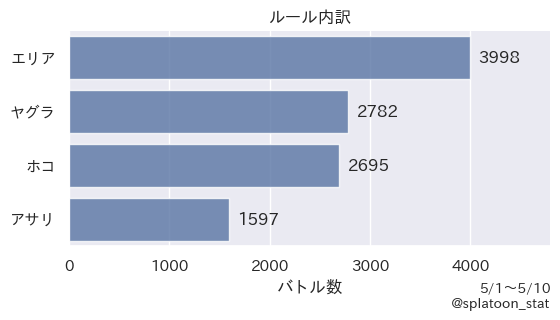

パワー不明バトル数: 447


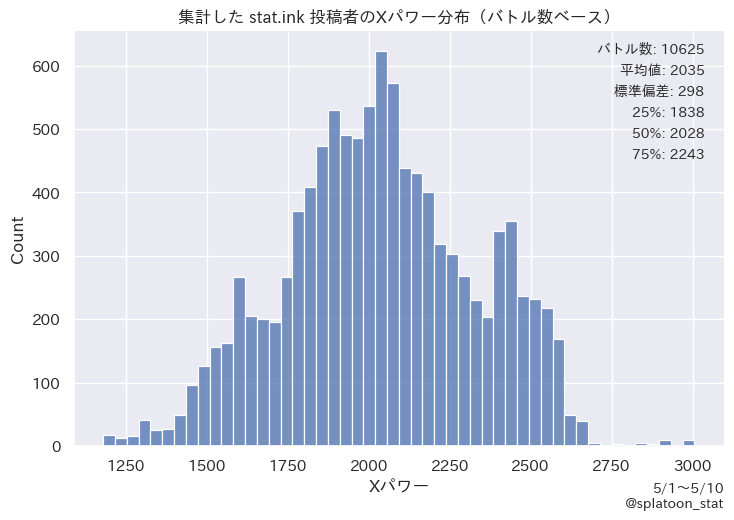

In [2]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [3]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [38]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
power = players.groupby(["mode", "weapon"])["power"].mean().to_frame("power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = weapon_stat.groupby("mode")["usage"].transform(lambda x: boxcox(x)[0])
weapon_stat["usage-z"] = weapon_stat.groupby("mode", group_keys=False)["usage-bc"].apply(standardize)
weapon_stat["power-z"] = weapon_stat.groupby("mode", group_keys=False)["power"].apply(standardize)

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
weapon_stat

usage        power  usage-bc   usage-z   power-z  \
mode   weapon                                                                  
area   sharp_neo         0.063210  2110.601793 -2.496107  2.022779  0.590683   
       screwslosher      0.056707  2217.613244 -2.584157  1.911800  1.875224   
       sshooter_collabo  0.051347  1971.235196 -2.664059  1.811090 -1.082242   
       liter4k           0.040520  2117.135714 -2.852264  1.573873  0.669115   
       kugelschreiber    0.038769  2207.423336 -2.887005  1.530086  1.752907   
...                           ...          ...       ...       ...       ...   
yagura promodeler_mg     0.001335  1952.626087 -4.641690 -1.497556 -0.526064   
       96gal             0.001284  2058.062500 -4.660042 -1.526933  0.782659   
       h3reelgun         0.001284  2102.050000 -4.660042 -1.526933  1.328651   
       carbon            0.000719  1905.108333 -4.921962 -1.946204 -1.115875   
       l3reelgun         0.000359  1892.028571 -5.213109 -2.412260 -1.278227   

                         strength  strength-z  strength-t  
mode   weapon                                              
area   sharp_neo         1.921751    1.880875   68.808754  
       screwslosher      2.671605    2.614779   76.147794  
       sshooter_collabo  0.674304    0.659961   56.599610  
       liter4k           1.631338    1.596639   65.966388  
       kugelschreiber    2.301908    2.252946   72.529464  
...                           ...         ...         ...  
yagura promodeler_mg    -1.480401   -1.448913   35.510870  
       96gal            -0.652793   -0.638908   43.610920  
       h3reelgun        -0.298200   -0.291857   47.081432  
       carbon           -2.204608   -2.157715   28.422847  
       l3reelgun        -2.664439   -2.607766   23.922344  

[316 rows x 8 columns]

### 可視化する

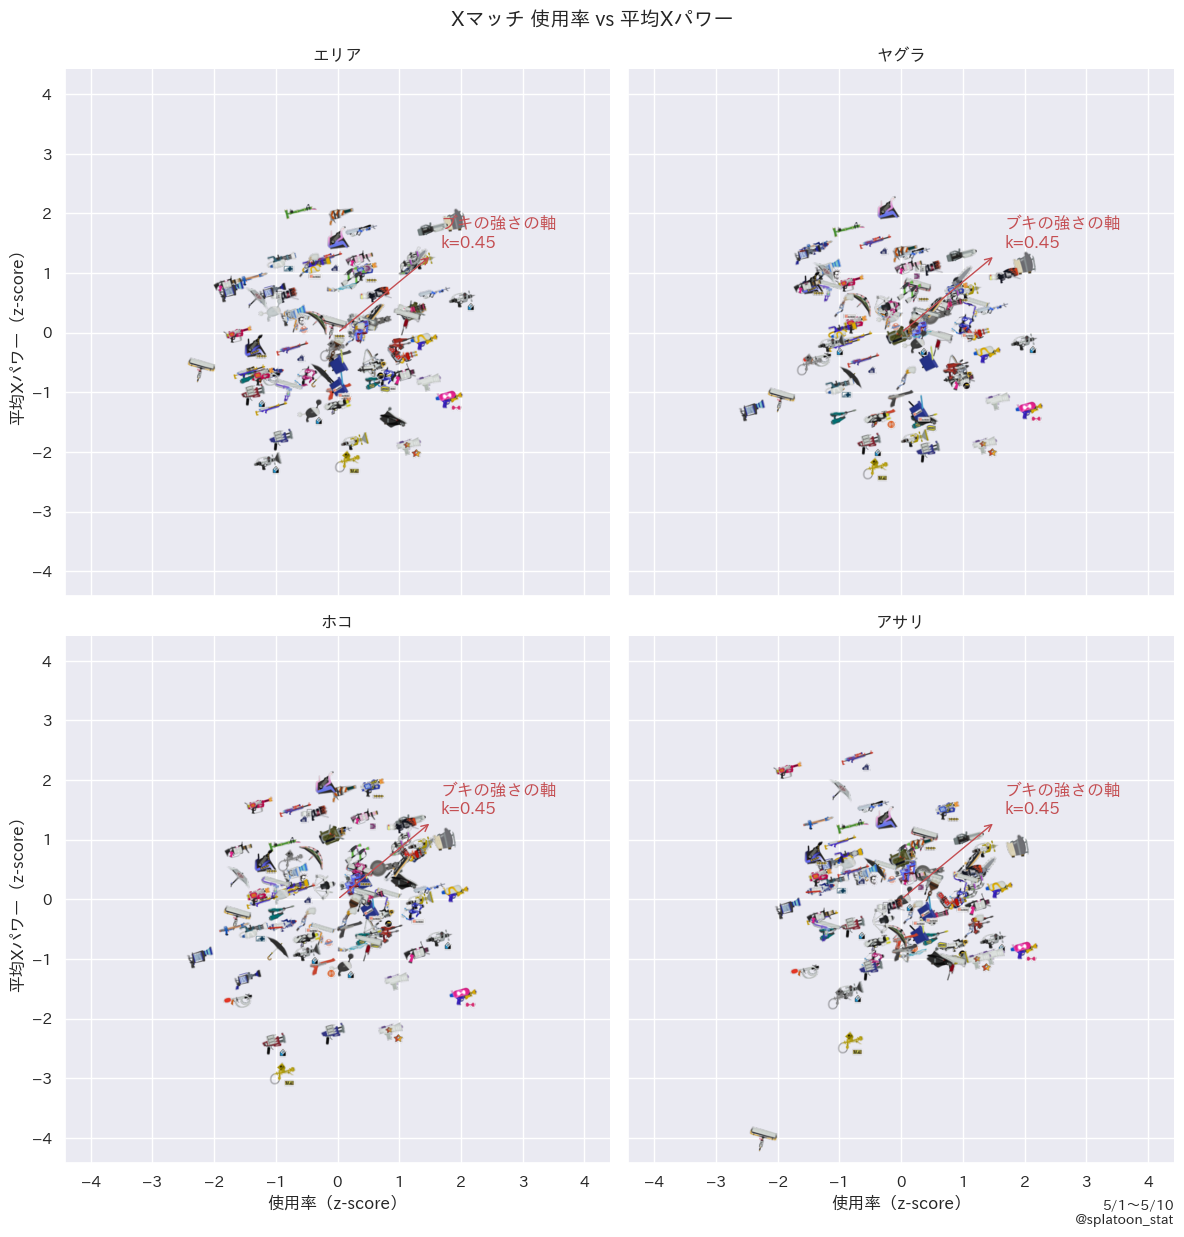

In [82]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均Xパワー（z-score）", "X Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均Xパワー", "Usage vs X Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=6,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.set(
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for _, row in weapon_stat.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["usage-z"]
        yvalue = row["power-z"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    # ブキの強さの軸のベクトルを表示する
    ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

In [95]:
strength_map = weapon_stat.reset_index().pivot(index="weapon", columns="mode", values="strength-t").reindex(d.MODE_ORDER, axis=1)
strength_map["mean"] = strength_map.mean(axis=1)
strength_map = strength_map.sort_values("mean", ascending=False)
strength_map


mode,area,yagura,hoko,asari,mean
weapon,,,,,
screwslosher,76.147794,72.326736,69.329451,69.752658,71.889160
kugelschreiber,72.529464,65.717033,67.259318,64.748311,67.563531
sharp,67.922665,62.684651,66.010555,65.598101,65.553993
jimuwiper,66.928665,62.874496,65.535112,63.206617,64.636223
longblaster,58.684241,68.499249,65.699076,60.945687,63.457063
...,...,...,...,...,...
clashblaster_neo,33.232583,34.364248,27.011001,41.323441,33.982818
soytuber,36.442998,36.939360,27.240811,30.745843,32.842253
l3reelgun,41.721912,23.922344,27.498512,35.667332,32.202525


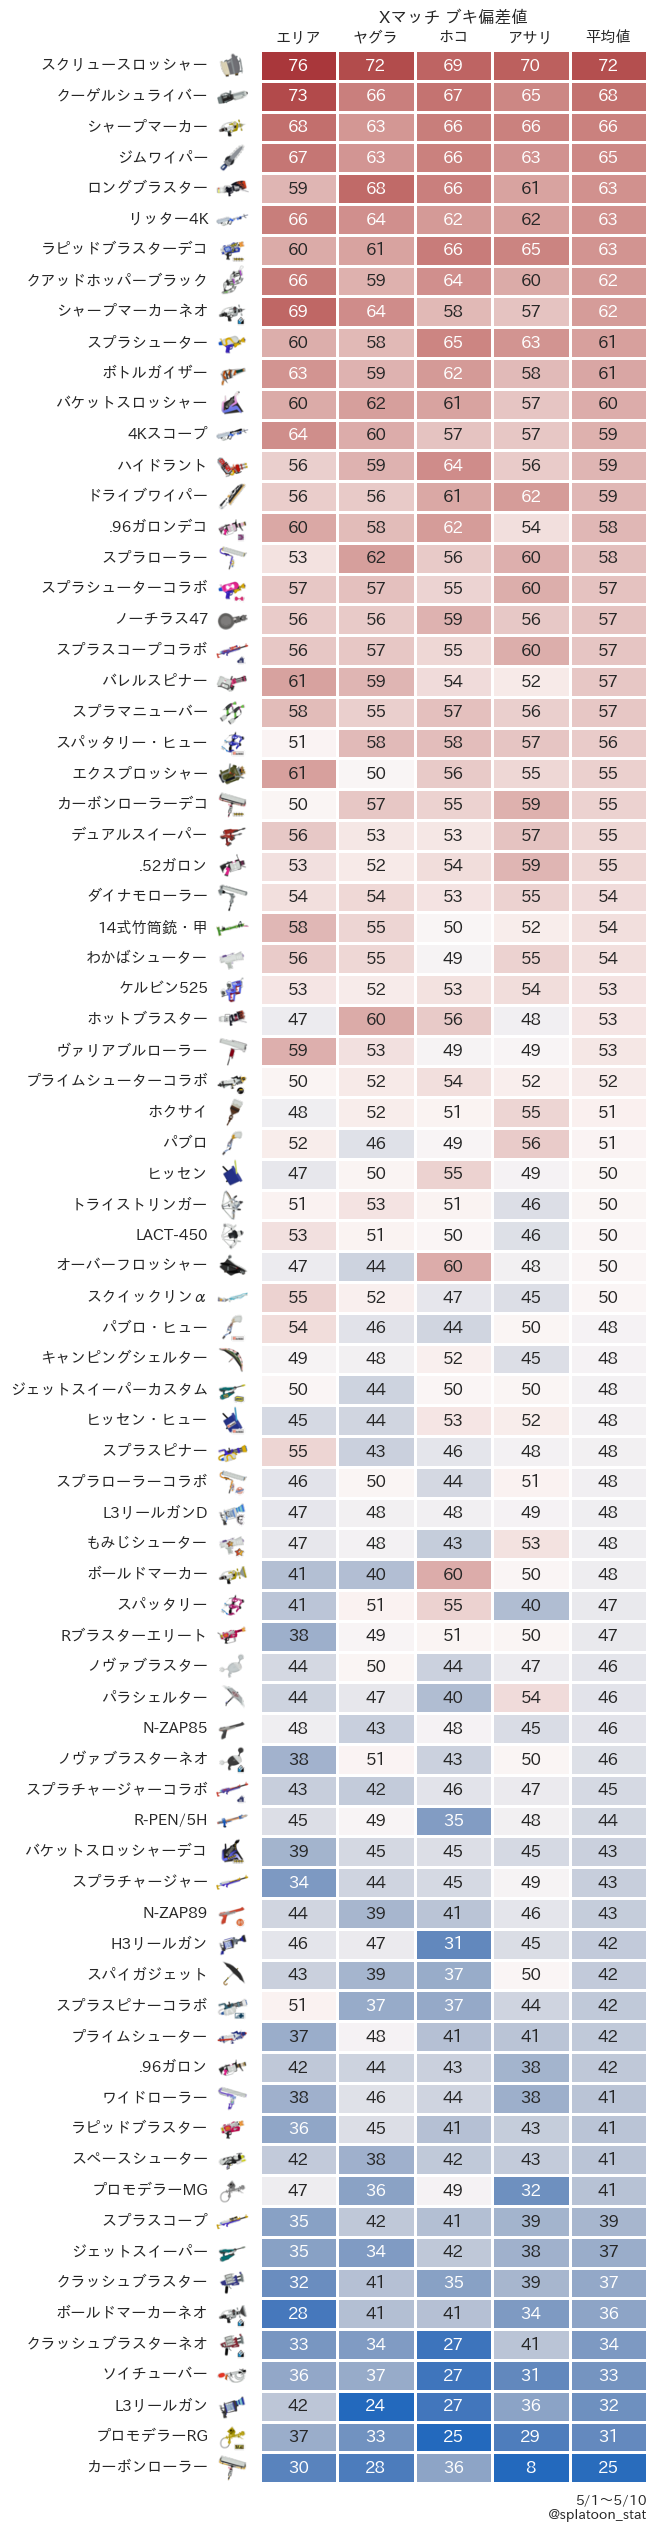

In [108]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

fig, ax = plt.subplots(figsize=(5, len(strength_map.index) * 0.4))
sns.heatmap(
    strength_map,
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=50,
    vmin=50-25,
    vmax=50+25,
    linewidths=2,
    ax=ax,
)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.35, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_data_duration(battles), .3)

plt.show()